In [ ]:
import numpy as np
import pandas as pd
#import seaborn as sb
import matplotlib.pyplot as plt
import random as rd
import array
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
from sklearn.linear_model import Perceptron

In [ ]:
dataTable = pd.read_csv('cardio_train.csv', delimiter=';').drop('id', 1)

In [ ]:
dataTable.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### 1.0 Cleaning Dataset

In [ ]:
def ageInYears(dataTable):
    ageInYears = []
    for i in range(len(dataTable)):
        ageInYears.append(int(round(dataTable.iloc[i]['age']/365)))
    return ageInYears

In [ ]:
ageInYears = ageInYears(dataTable)
dataTable['age_years'] = ageInYears

In [ ]:
cols = dataTable.columns.tolist()
cols.insert(0, cols.pop(cols.index('age_years')))
dataTable = dataTable.reindex(columns= cols)
del dataTable['age']
dataTable.columns = ['Age_years', 'Gender', 'Height', 'Weight', 'Systolic_bp', 'Diastolic_bp', 'Cholesterol', 'Glucose', 'Smoking', 'Alcohol_intake', 'Physical_activity', 'Cardio_disease' ]

In [ ]:
dataTable.head()

### 2.0 Algorithms

In [ ]:
atributes = dataTable.values[:,:-1]
classes = dataTable.values[:,-1]
xTrain, xTest, yTrain, yTest = train_test_split(atributes, classes, test_size = 0.25)

### 2.1 KNN

In [ ]:
def matriz_covariance(x1, x2):
    return 1

def euclidean_distance(testRow, trainRow):
    distance = 0.0
    for i in range(len(testRow)):
        distance += (testRow[i] - trainRow[i])**2
    return sqrt(distance)

def get_neighbors(train, yTrain, testRow, num_neighbors):
    distances = list()
    for i in range(train.shape[0]):
        dist = euclidean_distance(testRow, train[i])
        distances.append((train[i], dist, yTrain[i]))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append((distances[i][0], distances[i][2]))
    return neighbors

def predict_classification(train, test, num_neighbors):
    prediction = list()
    for i in range(test.shape[0]):
        neighbors = get_neighbors(train, test.iloc[i], num_neighbors)
        output_values = [row[-1] for row in neighbors]
        prediction.append(max(set(output_values), key=output_values.count))
    return prediction

def knn(xTrain, yTrain, xTest, numNeighbors):
    prediction = list()
    for i in range(len(xTest)):
        neighbors = get_neighbors(xTrain, yTrain, xTest[i], numNeighbors)
        output_values = [row[-1] for row in neighbors]
        prediction.append(max(set(output_values), key=output_values.count))
    return prediction

NAO RODAR A CELULA ABAIXO NOVAMENTE!

In [ ]:
neighbors = 3
predicted = knn(xTrain, yTrain, xTest, neighbors)

### 2.1.1 KNN Metrics

In [ ]:
def accuracy(predicted, actual):
    total = 0;
    for a,p in zip(actual, predicted):
        if (a == p):
            total +=1;
    return (total/len(actual))*100

In [ ]:
accuracy(predicted, yTest)

67.24571428571429

In [ ]:
print(classification_report(yTest, predicted))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      8718
         1.0       0.68      0.66      0.67      8782

    accuracy                           0.67     17500
   macro avg       0.67      0.67      0.67     17500
weighted avg       0.67      0.67      0.67     17500



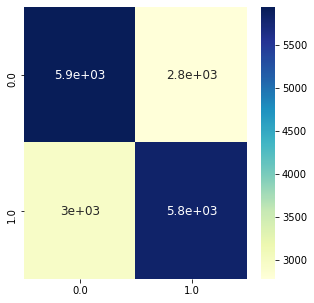

In [ ]:
confMatrix = confusion_matrix(yTest, predicted)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0.0,1.0
0.0,5941,2777
1.0,2955,5827


## 2.2 Gaussian discriminant analysis

In [ ]:
def train_gaussian_discriminant_analysis(matrix_x, vector_y):
    
    classes, num_occurrences = np.unique(vector_y, return_counts=True)
    
    odds =  num_occurrences / len(vector_y)
    
    means = np.ones((len(classes), matrix_x.shape[1]) , dtype=float)
    
    covariance = np.ones((len(classes), matrix_x.shape[1], matrix_x.shape[1]), dtype=float)
        
    for k in range(len(classes)):
        
        class_element = matrix_x[vector_y==k]    
        
        means[k] = np.mean(class_element, axis=0)
        
        sum_cov = np.ones((matrix_x.shape[1], matrix_x.shape[1]), dtype=float)
        
        for i in range (class_element.shape[0]):    
            sum_cov += np.outer((class_element[i] - means[k]),(class_element[i] - means[k]))
        covariance[k] = sum_cov /(num_occurrences[k] -1)         

    return means, covariance, odds

In [ ]:
def make_predict_gda(x, means, covariance, odds, d):
    
    num_classes = len(odds)
    
    odds_class = np.zeros(num_classes)     
    
    for k in range(num_classes):
        
        determinante = np.linalg.det(covariance[k])
                
        part1 = np.log2(determinante)
        
        part2 = (np.transpose(x - means[k]).dot(np.linalg.inv(covariance[k]))).dot(x - means[k])
        
        prediction = np.log2(odds[k]) -1/2 * part1 -1/2 * part2 
        
        odds_class[k] = prediction
        
    return odds_class

In [ ]:
def gaussian_discriminant_analysis(xTrain, yTrain, xTest):
    
    means, covariance, odds = train_gaussian_discriminant_analysis(xTrain, yTrain)
    arrau_p = []
    size = (xTrain.shape[0], len(odds))
    predictions = np.ones(size, dtype=float)
    d = xTrain.shape[1]
    
    for i in range(xTest.shape[0]):
        predictions[i] = make_predict_gda(xTest[i], means, covariance, odds, d)
        index = np.argmax(predictions[i], axis=0)
        arrau_p.append(index)
            
    return np.array(arrau_p)

In [ ]:
predictions = gaussian_discriminant_analysis(xTrain, yTrain, xTest)

In [ ]:
accuracy(predictions, yTest)

57.32000000000001

In [ ]:
print(classification_report(yTest, predictions))

              precision    recall  f1-score   support

         0.0       0.54      0.90      0.68      8686
         1.0       0.72      0.25      0.37      8814

    accuracy                           0.57     17500
   macro avg       0.63      0.58      0.52     17500
weighted avg       0.63      0.57      0.52     17500



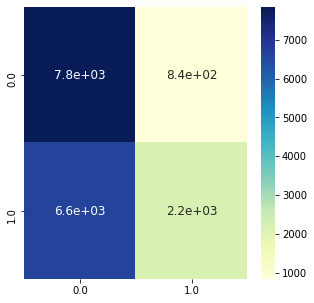

In [ ]:
confMatrix = confusion_matrix(yTest, predictions)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0.0,1.0
0.0,7843,843
1.0,6626,2188


0.5755943527767375


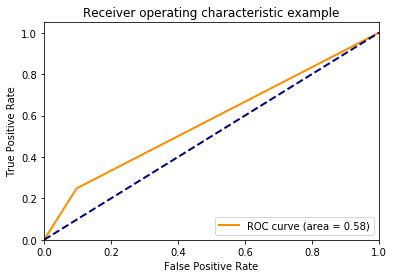

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(yTest, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(yTest, predictions))
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 2.2.1 Naive Gaussian discriminant analysis

In [ ]:
def compute_NaiveGaussians(xTrain,yTrain):
    means = list()
    variances = list()
    prob = list()
    
     
    for i in range(int(np.amax(yTrain))+1): #np.amax indicates the number of Classes (assuming each class identifies as an integer starting with 0)
        means.append(np.mean(xTrain[np.argwhere(yTrain == i)] , 0 ))
        variances.append(np.std(xTrain[np.argwhere(yTrain == i)] , 0 )) 
        prob.append(len(np.argwhere(yTrain ==i)) /len(yTrain))
 
    return prob, means, variances


def NBayes_Gaussian(xTrain, yTrain, xTest): 
    prob, means, variances = compute_NaiveGaussians(xTrain,yTrain)
    prediction = list() 
    APLog = np.zeros([len(xTest),len(prob) ])   
    for i in range(len(xTest)):
        for j in range(len(prob)): 
            APLog[i,j] = prob[j] - 1/2*np.sum(np.log(2*np.pi*variances[j]))-1/2*np.sum(np.divide(np.square(xTest[i]-means[j]),variances[j]))
         
 
    prediction = np.argmax(APLog,1)  
     
            
    return prediction

In [ ]:
predictions = NBayes_Gaussian(xTrain, yTrain, xTest)

In [ ]:
accuracy(predictions, yTest)

66.21142857142857

In [ ]:
print(classification_report(yTest, predictions))

              precision    recall  f1-score   support

         0.0       0.63      0.77      0.69      8686
         1.0       0.71      0.56      0.62      8814

    accuracy                           0.66     17500
   macro avg       0.67      0.66      0.66     17500
weighted avg       0.67      0.66      0.66     17500



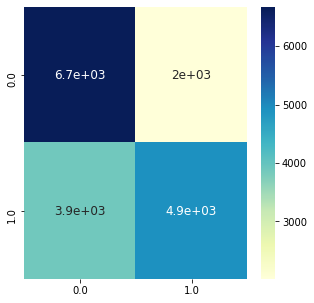

In [ ]:
confMatrix = confusion_matrix(yTest, predictions)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0.0,1.0
0.0,6670,2016
1.0,3897,4917


0.662882431561661


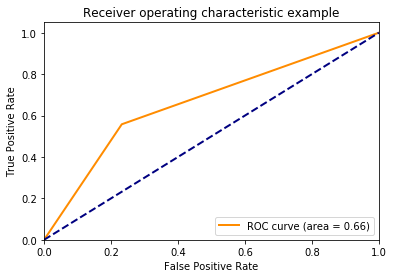

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(yTest, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(yTest, predictions))
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 2.2.2 Naive Laplacian discriminant analysis

In [ ]:
def compute_NaiveLaplacian(xTrain,yTrain):
    means = list()
    variances = list()
    prob = list()
    
     
    for i in range(int(np.amax(yTrain))+1): #np.amax indicates the number of Classes (assuming each class identifies as an integer starting with 0)
        means.append(np.mean(xTrain[np.argwhere(yTrain == i)] , 0 ))
        variances.append(np.std(xTrain[np.argwhere(yTrain == i)] , 0 )) 
        prob.append(len(np.argwhere(yTrain ==i)) /len(yTrain))
 
    return prob, means, variances


def NBayes_Laplacian(xTrain, yTrain, xTest): 
    prob, means, variances = compute_NaiveLaplacian(xTrain,yTrain)
    prediction = list() 
    APLog = np.zeros([len(xTest),len(prob) ])   
    for i in range(len(xTest)):
        for j in range(len(prob)): 
            APLog[i,j] = prob[j] - np.sum(np.log(np.sqrt(2)*np.sqrt(variances[j])))-1/2*np.sum(np.divide(np.abs(xTest[i]-means[j]),np.sqrt(variances[j]/2.0)))
             
 
    prediction = np.argmax(APLog,1)  
     
            
    return prediction

In [ ]:
predictions = NBayes_Laplacian(xTrain, yTrain, xTest)

In [ ]:
accuracy(predictions, yTest)

64.03999999999999

In [ ]:
print(classification_report(yTest, predictions))

              precision    recall  f1-score   support

         0.0       0.59      0.92      0.72      8668
         1.0       0.82      0.37      0.51      8832

    accuracy                           0.64     17500
   macro avg       0.70      0.64      0.61     17500
weighted avg       0.70      0.64      0.61     17500



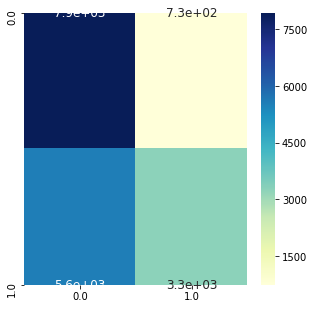

In [ ]:
confMatrix = confusion_matrix(yTest, predictions)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0.0,1.0
0.0,7935,733
1.0,5560,3272


0.6429535506243187


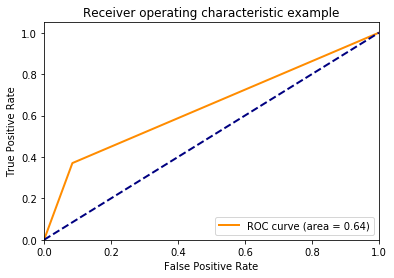

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(yTest, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(yTest, predictions))
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Logistic regression

In [ ]:
def normalization(matrix, vector):
    #Mean calculation
    mVector = np.mean(vector, axis=0)
    mMatrix = np.mean(matrix, axis=0)
    
    #Standard deviation
    stdVector = np.std(vector, axis = 0)
    stdMatrix = np.std(matrix, axis = 0)
     
    #Normalization of data
    vector = (vector - mVector)/stdVector
    matrix = (matrix - mMatrix)/stdMatrix
    
    return matrix, vector

In [ ]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def predict_logistic_regression_binary(matrix_x, w):
    
    predictions = []
    matrix_x = np.insert(matrix_x, 0, 1, axis =1)
    for i in range(matrix_x.shape[0]):
        predictions.append(round(sigmoide(matrix_x[i].dot(w))))
        
    return predictions

In [ ]:
def predict_logistic_regression_binary_proba(matrix_x, w):
    
    predictions = []
    matrix_x = np.insert(matrix_x, 0, 1, axis =1)
    for i in range(matrix_x.shape[0]):
        predictions.append(sigmoide(matrix_x[i].dot(w)))
        
    return predictions

In [ ]:
def stochastic_gradient_descent(matrix_x, vector_y, epochs, alpha):
    matrix_x = np.insert(matrix_x, 0, 1, axis =1)
    w_matrix = np.ones((matrix_x.shape[1],), dtype=float)
    y_predicted = matrix_x.dot(w_matrix)
    data =np.append(matrix_x, np.split(vector_y, matrix_x.shape[0], axis=0), axis=1)
    mse = []

    for epoch in range(epochs):
        erro = 0
        somatorio = 0
        for i in range(matrix_x.shape[0]):
            w_matrix  = w_matrix + alpha * (vector_y[i] - sigmoide(y_predicted[i])) * matrix_x[i]
            somatorio += (vector_y[i] - sigmoide(y_predicted[i])) * matrix_x[i]
        
        mse.append((-1/matrix_x.shape[0]) * somatorio)        
        data = np.random.permutation(data)
        matrix_x = data[: ,0:matrix_x.shape[1]]
        vector_y = data[:,matrix_x.shape[1]]
        
        y_predicted = matrix_x.dot(w_matrix)  
    
    return w_matrix, mse

In [ ]:
matrix_x, vector_y = normalization(xTrain, yTrain)

In [ ]:
matrix_x_test, vector_y_test = normalization(xTest, yTest)

In [ ]:
w, mse = stochastic_gradient_descent(matrix_x, vector_y, 1000, 0.001)

In [ ]:
predictions_logistic = predict_logistic_regression_binary(matrix_x_test, w)

In [ ]:
predictions_logistic_proba = predict_logistic_regression_binary_proba(matrix_x_test, w)

In [ ]:
accuracy(predictions_logistic, yTest)

57.19428571428572

In [ ]:
print(classification_report(yTest, predictions_logistic))

              precision    recall  f1-score   support

         0.0       0.54      0.93      0.68      8686
         1.0       0.77      0.22      0.34      8814

    accuracy                           0.57     17500
   macro avg       0.65      0.57      0.51     17500
weighted avg       0.65      0.57      0.51     17500



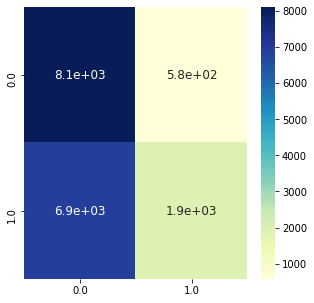

In [ ]:
confMatrix = confusion_matrix(yTest, predictions_logistic)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0.0,1.0
0.0,8181,595
1.0,6820,1904


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.583


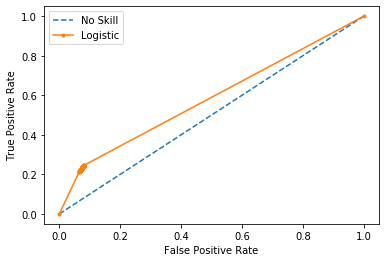

In [ ]:
ns_probs = [0 for _ in range(len(yTest))]
# fit a model
# predict probabilities
lr_probs = predictions_logistic_proba
# keep probabilities for the positive outcome only
lr_probs = lr_probs
# calculate scores
ns_auc = roc_auc_score(yTest, ns_probs)
lr_auc = roc_auc_score(yTest, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(yTest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(yTest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Teste linearidade com perceptron

In [ ]:
clf = Perceptron(tol=1e-3, random_state=0)

In [ ]:
clf.fit(xTrain, yTrain)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
clf.score(xTest, yTest)

0.5428571428571428

In [ ]:
preds = clf.predict(xTest)

In [ ]:
confMatrix = confusion_matrix(yTest, preds)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

In [ ]:
confMatrixDF

,0.0,1.0
0.0,8597,165
1.0,7835,903


In [ ]:
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(xTrain, yTrain)
preds = clf.predict(xTest)
confMatrix = confusion_matrix(yTest, preds)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))
confMatrixDF

,0.0,1.0
0.0,8597,165
1.0,7835,903


## Árvore de Decisão

In [ ]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
decisiontree = tree.DecisionTreeClassifier()

criterion = ['gini', 'entropy']
max_depth = [6,7,8,9,10]

parameters = dict(decisiontree__criterion=criterion,
                  decisiontree__max_depth=max_depth)

param_grid = [{'criterion': ['gini'], 'max_depth': [6,7,8,9,10]},
              {'criterion': ['entropy'], 'max_depth':[6,7,8,9,10]}]


In [ ]:
clf = GridSearchCV(decisiontree, param_grid)

# Fit the grid search
clf.fit(X, y)

# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['max_depth'])

Best Criterion: entropy
Best max_depth: 7


In [ ]:
decisiontree_ = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
tree_clf = decisiontree_.fit(X,y)

In [ ]:
tree_clf.tree_

In [ ]:
tree_clf.score(X_test,y_test)

0.7356

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
output = tree_clf.predict(X_test)

In [ ]:
len(y_test)

17500

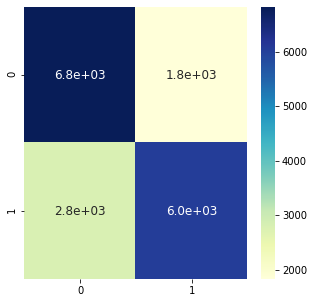

In [ ]:
confMatrix = confusion_matrix(y_test, output)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0,1
0,6823,1830
1,2797,6050


In [ ]:
print(classification_report(y_test, output))
#confMatrix = confusion_matrix(y_test, output)

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      8653
           1       0.77      0.68      0.72      8847

    accuracy                           0.74     17500
   macro avg       0.74      0.74      0.74     17500
weighted avg       0.74      0.74      0.73     17500



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


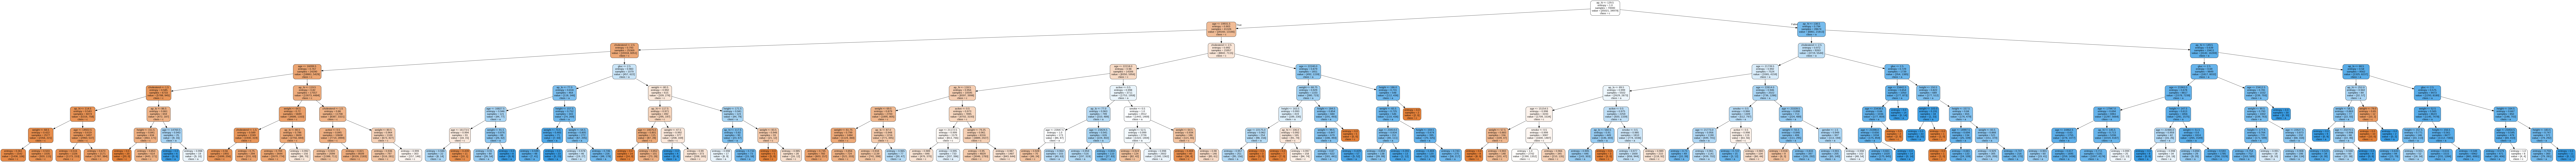

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image

dot_data = StringIO()

export_graphviz(tree_clf,
                out_file=dot_data,
                feature_names=X.columns.tolist() , #feature_names[2:],
                class_names='cardio',
                rounded=True,
                filled=True)

#! dot -Tpng iris_clf.dot -o iris_clf.png 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('/content/drive/My Drive/Aprendizagem de Máquina/cardio.png')
Image(graph.create_png())

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

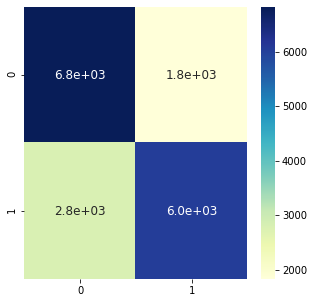

In [ ]:
confMatrix = confusion_matrix(y_test, output)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.736


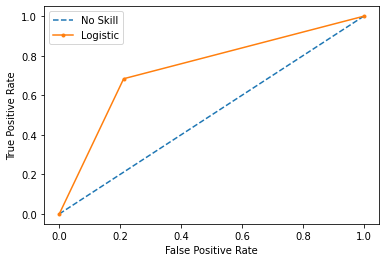

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
lr_probs = output
# keep probabilities for the positive outcome only
lr_probs = lr_probs
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(gamma='auto')
param_grid = [{'kernel': ['rbf'], 'C': 2 ** np.arange(-1.0, 3, 2),
                                  'gamma': 2 ** np.arange(-12.0, -6.0, 2)}]

model = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=5)

model.fit(X_train, y_train) 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 33.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': array([0.5, 2. ]),
                          'gamma': array([0.00024414, 0.00097656, 0.00390625]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [ ]:
support_vectors = model.best_estimator_.support_vectors_

print("Melhores hiperparâmetros:")
print(model.best_params_)
print("%d vetores suportes de %d dados de treinamento (%.2f%% dos exemplos)." \
      % (support_vectors.shape[0], X_train.shape[0], 100*support_vectors.shape[0]/X_train.shape[0]))

Melhores hiperparâmetros:
{'C': 2.0, 'gamma': 0.000244140625, 'kernel': 'rbf'}
33320 vetores suportes de 52500 dados de treinamento (63.47% dos exemplos).


### Rodando com os hiperparâmetros do grid_search
### C = 2.0 e gamma = 2** -12 = 0.000244140625

In [ ]:
model = SVC(kernel='rbf',C=2,gamma=0.000244140625)
model.fit(X_train,y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.000244140625, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model.score(X_test,y_test)

0.7200571428571428

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6729 2050]
 [2849 5872]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      8779
           1       0.74      0.67      0.71      8721

    accuracy                           0.72     17500
   macro avg       0.72      0.72      0.72     17500
weighted avg       0.72      0.72      0.72     17500



In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sb

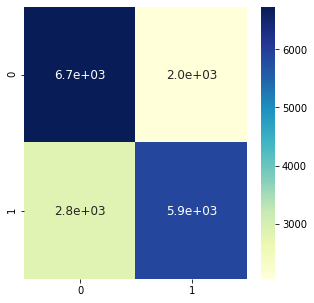

In [ ]:
confMatrix = confusion_matrix(y_test, y_pred)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [ ]:
confMatrixDF

,0,1
0,6729,2050
1,2849,5872


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.717


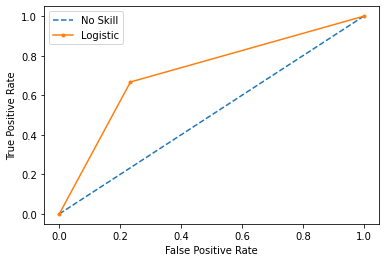

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
lr_probs = y_pred
# keep probabilities for the positive outcome only
lr_probs = lr_probs
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()